In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

import histlib.matchup as match
import histlib.diagnosis as diag
from histlib.cstes import labels, zarr_dir, matchup_dir, var2, var, c0, c1
from histlib.matchup import _data_var, _stress_var, _aviso_var
from  histlib.diagnosis import global_ms_drifter_sat_year, compute_sum_ms, nMSRe_id, C_x, true_err_x, plot_closure_bar, plot_cor_uncor_part, global_drifter_sat

from xhistogram.xarray import histogram


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm


/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## IMPORT DATA, build dataset
We choose to get only erastar wind term, and we reject PEACHY data, and we select only deltaT<1H

In [2]:
id_aviso = 'aviso__25__adt__es_cstrio_z15__alti_x'
id_aviso_drifter = 'aviso__25__adt__es_cstrio_z15__drifter_x'
id_co = 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x'
id_aviso_drifter_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'aviso_drifter_ggx_adt','wind':'es_cstrio_z15_drifter_wd_x'}
id_co_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wind':'es_cstrio_z15_drifter_wd_x'}
id_aviso_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'aviso_alti_ggx_adt','wind':'es_cstrio_z15_alti_wd_x'}

var = list(id_co_dic.values())+list(id_aviso_dic.values())+list(id_aviso_drifter_dic.values())+['nb_coloc_bin']+['sum_'+v for v in [id_aviso, id_co, id_aviso_drifter]]+['sum_'+v for v in [id_aviso, id_co, id_aviso_drifter]]+['exc_acc_'+v for v in [id_aviso, id_co, id_aviso_drifter]]+['exc_coriolis_'+v for v in [id_aviso, id_co, id_aviso_drifter]]+['exc_ggrad_'+v for v in [id_aviso, id_co, id_aviso_drifter]]+['exc_wind_'+v for v in [id_aviso, id_co, id_aviso_drifter]]


import itertools
corr_key_co = list(itertools.combinations(list(id_co_dic.values()),2))
corr_key_av = list(itertools.combinations(list(id_aviso_dic.values()),2)) 
corr_var_co = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_co]
corr_var_aviso = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_av]

In [3]:
dl = 5
dt = 10*60

In [4]:
def put_fig_letter(ax, letter):
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, letter+')', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

___________
__________
# Distance dependency

In [5]:
files_ms = glob(os.path.join(zarr_dir+'_ok',f'msdist/msdist_{int(dl)}_drogued_*.zarr'))
files_ms = [f for f in files_ms if 'gps' in f]
files_mean = glob(os.path.join(zarr_dir+'_ok',f'meandist/meandist_{int(dl)}_drogued_*.zarr'))
files_mean = [f for f in files_mean if 'gps' in f]
files_corr = glob(os.path.join(zarr_dir+'_ok',f'corrdist/corrdist_{int(dl)}_drogued_*.zarr'))
files_corr = [f for f in files_corr if 'gps' in f]

In [6]:
dsms = xr.open_mfdataset(files_ms)[var].rename({'nb_coloc_bin':'nb_coloc'}).isel(distbin=slice(0,-1)).compute()# remove weird last point
dsmean = xr.open_mfdataset(files_mean)[var].rename({'nb_coloc_bin':'nb_coloc'}).isel(distbin=slice(0,-1)).compute()
dscorr = xr.open_mfdataset(files_corr).rename({'nb_coloc_bin':'nb_coloc'}).isel(distbin=slice(0,-1)).compute()

In [7]:
dsms

<xarray.Dataset>
Dimensions:                                                                               (
                                                                                           drifter_sat_year: 40,
                                                                                           distbin: 39)
Coordinates:
  * distbin                                                                               (distbin) float64 ...
  * drifter_sat_year                                                                      (drifter_sat_year) <U21 ...
Data variables: (12/23)
    drifter_acc_x_25                                                                      (drifter_sat_year, distbin) float64 ...
    drifter_coriolis_x_25                                                                 (drifter_sat_year, distbin) float64 ...
    alti_ggx_adt_filtered_ocean_tide_internal_tide                                        (drifter_sat_year, distbin) float64 ...
    es_cstrio_z15_drifter_wd_x                                                            (drifter_sat_year, distbin) float64 ...
    aviso_alti_ggx_adt                                                                    (drifter_sat_year, distbin) float64 ...
    es_cstrio_z15_alti_wd_x                                                               (drifter_sat_year, distbin) float64 ...
    ...                                                                                    ...
    exc_ggrad_aviso__25__adt__es_cstrio_z15__alti_x                                       (drifter_sat_year, distbin) float64 ...
    exc_ggrad_co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x     (drifter_sat_year, distbin) float64 ...
    exc_ggrad_aviso__25__adt__es_cstrio_z15__drifter_x                                    (drifter_sat_year, distbin) float64 ...
    exc_wind_aviso__25__adt__es_cstrio_z15__alti_x                                        (drifter_sat_year, distbin) float64 ...
    exc_wind_co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x      (drifter_sat_year, distbin) float64 ...
    exc_wind_aviso__25__adt__es_cstrio_z15__drifter_x                                     (drifter_sat_year, distbin) float64 ...

In [8]:
alpha=0.01
def error_on_covariances(dscorr, dsms , corr_id, alpha=0.01):
    def compute_contribution_errors(ms12, ms1, ms2, N, alpha):
        import scipy.stats as sps
        rho = ms12/np.sqrt(ms1*ms2)
        dist = sps.norm(loc=0, scale=1)
        q5 = -dist.ppf(alpha)
        return q5*(1+rho**2)*np.sqrt(ms1*ms2)/np.sqrt(N)
    ds_cov_err = xr.Dataset()
    for prod in corr_id :
            ms12 = 'prod_'+'__'.join(prod)
            ms1, ms2 = prod
            ds_cov_err[ms12] = compute_contribution_errors(dscorr[ms12], dsms[ms1]-dsms[ms1]**2, dsms[ms2]-dsms[ms2]**2, dscorr['nb_coloc'], alpha)
    return ds_cov_err

ds_cov_err = error_on_covariances(dscorr, dsms , corr_key_co+corr_key_av)

In [9]:
gps = [l for l in dsms.drifter_sat_year.values if 'gps' in l]
dsd, mslow, msup = global_ms_drifter_sat_year(dsmean.sel(drifter_sat_year=gps), dsms.sel(drifter_sat_year=gps), alpha=0.01)
mserr = (msup-mslow)/2

dsdc = -2* global_drifter_sat(dscorr)# balanced contribution
dsdce = -2*error_on_covariances(global_drifter_sat(dscorr), dsd, corr_key_co+corr_key_av)
dsdc['distbin']=dsdc['distbin']/1000
dsdce['distbin']=dsdce['distbin']/1000
dsd['distbin']=dsd['distbin']/1000
mserr['distbin']=mserr['distbin']/1000


<xarray.DataArray 'nb_coloc' (distbin: 39)>
array([26942., 30340., 30038., 29228., 29478., 29445., 29489., 29418.,
       29508., 29308., 29247., 29334., 29260., 29317., 29280., 29644.,
       29218., 29475., 29068., 28999., 28999., 28971., 29089., 28765.,
       29272., 29017., 29003., 29146., 29111., 28917., 28833., 28877.,
       28739., 28573., 28926., 28525., 28688., 28692., 28399.])
Coordinates:
  * distbin  (distbin) float64 2.5e+03 7.5e+03 1.25e+04 ... 1.875e+05 1.925e+05
<xarray.DataArray 'nb_coloc' (distbin: 39)>
array([26942., 30340., 30038., 29228., 29478., 29445., 29489., 29418.,
       29508., 29308., 29247., 29334., 29260., 29317., 29280., 29644.,
       29218., 29475., 29068., 28999., 28999., 28971., 29089., 28765.,
       29272., 29017., 29003., 29146., 29111., 28917., 28833., 28877.,
       28739., 28573., 28926., 28525., 28688., 28692., 28399.])
Coordinates:
  * distbin  (distbin) float64 2.5e+03 7.5e+03 1.25e+04 ... 1.875e+05 1.925e+05
<xarray.DataArray 'nb_coloc' (

_____________
# Covariance

In [10]:
def exp_decay(dx, dx_constant, amplitude, cst):
    return np.exp(-dx / dx_constant) * 2e-10*amplitude +cst

cor_alg = dsdc.prod_drifter_coriolis_x_25__alti_ggx_adt_filtered_ocean_tide_internal_tide
acc_alg = dsdc.prod_drifter_acc_x_25__alti_ggx_adt_filtered_ocean_tide_internal_tide
cor_av = dsdc.prod_drifter_coriolis_x_25__aviso_alti_ggx_adt
acc_av = dsdc.prod_drifter_acc_x_25__aviso_alti_ggx_adt
cor_av_d = dsdc.prod_drifter_coriolis_x_25__aviso_drifter_ggx_adt
acc_av_d = dsdc.prod_drifter_acc_x_25__aviso_drifter_ggx_adt
cor_wd_alti = dsdc.prod_drifter_coriolis_x_25__es_cstrio_z15_alti_wd_x
cor_wd_drifter = dsdc.prod_drifter_coriolis_x_25__es_cstrio_z15_drifter_wd_x


e_cor_alg = dsdce.prod_drifter_coriolis_x_25__alti_ggx_adt_filtered_ocean_tide_internal_tide
e_acc_alg = dsdce.prod_drifter_acc_x_25__alti_ggx_adt_filtered_ocean_tide_internal_tide
e_cor_av = dsdce.prod_drifter_coriolis_x_25__aviso_alti_ggx_adt
e_acc_av = dsdce.prod_drifter_acc_x_25__aviso_alti_ggx_adt

fit_cor_alg = cor_alg.curvefit("distbin", exp_decay)
fit_acc_alg = acc_alg.curvefit("distbin", exp_decay)
fit_cor_av = cor_av.curvefit("distbin", exp_decay)
fit_acc_av = acc_av.curvefit("distbin", exp_decay)
fit_cor_wd_alti = cor_wd_alti.curvefit("distbin", exp_decay)

## Zoom on wind

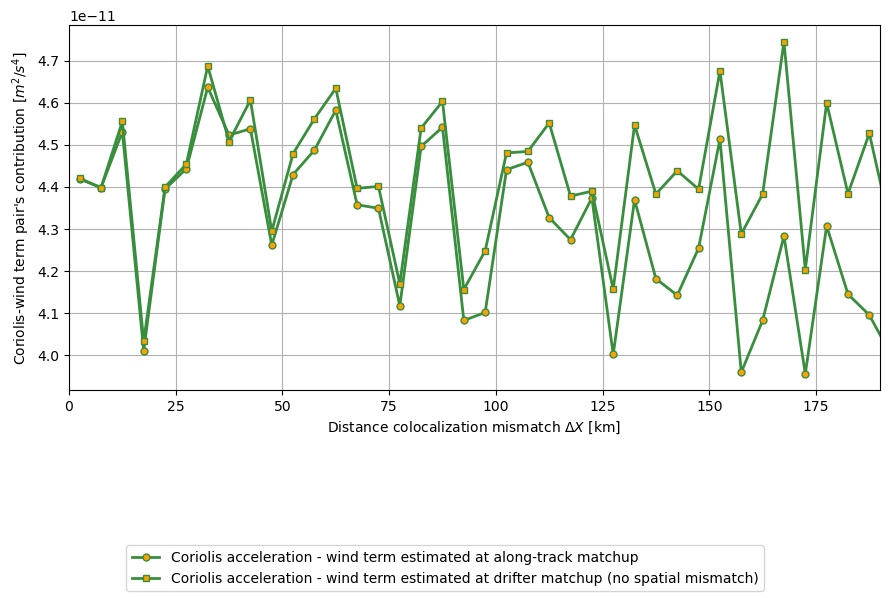

In [11]:
fig, ax = plt.subplots(1,1, figsize=(9,6))

cor_wd_alti.plot(c = c0['coriolis'], marker = 'o', markerfacecolor=c0['wind'], markersize=5, lw=2, label= 'Coriolis acceleration - wind term estimated at along-track matchup')
cor_wd_drifter.plot(c = c0['coriolis'], marker = 's', markerfacecolor=c0['wind'], markersize=5, lw=2, label= 'Coriolis acceleration - wind term estimated at drifter matchup (no spatial mismatch)')

ax.grid()
ax.set_ylabel("Coriolis-wind term pair's contribution $[m^2/s^4]$")
ax.set_xlabel('Distance colocalization mismatch $\Delta X$ [km]')
ax.set_xlim(0,190)
fig.legend(ncol=1,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.24,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.savefig('images/dist_ekman_cov.png',bbox_inches='tight',   dpi=300)

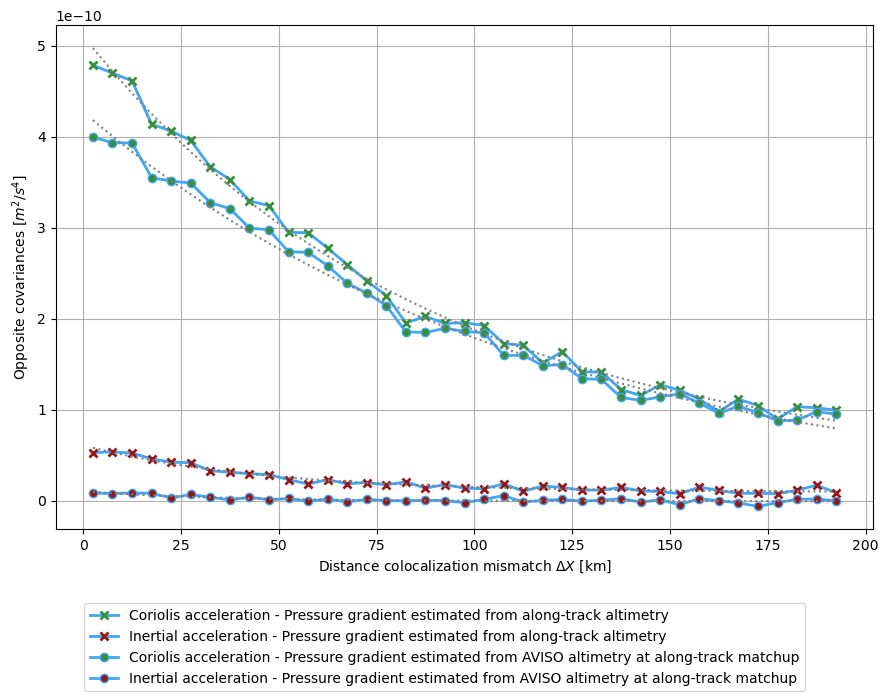

In [12]:
fig, ax = plt.subplots(1,1, figsize=(9,7))

cor_alg.plot(c = c0['ggrad'], marker = 'x', markeredgewidth = 2, markeredgecolor=c0['coriolis'], lw=2, label= 'Coriolis acceleration - Pressure gradient estimated from along-track altimetry')
acc_alg.plot(c = c0['ggrad'], marker = 'x', markeredgewidth = 2, markeredgecolor=c0['acc'],  lw=2, label= 'Inertial acceleration - Pressure gradient estimated from along-track altimetry')
cor_av.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['coriolis'],  lw=2, label= 'Coriolis acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')
acc_av.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['acc'],lw=2, label= 'Inertial acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')


exp_decay(cor_alg.distbin, *fit_cor_alg.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(acc_alg.distbin, *fit_acc_alg.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(cor_av.distbin, *fit_cor_av.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(acc_av.distbin, *fit_acc_av.curvefit_coefficients).plot(ls=':', c='grey')

ax.grid()
ax.set_ylabel('Opposite covariances $[m^2/s^4]$')
ax.set_xlabel('Distance colocalization mismatch $\Delta X$ [km]')
ax.set_title('')

fig.legend(ncol=1,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.15,1,1])#left, bottom, right, top (default is 0,0,1,1)

______________________
# Exponential fit


In [13]:
for da in [fit_cor_alg, fit_acc_alg, fit_cor_av, fit_acc_av, fit_cor_wd_alti]:
    dx = da.sel(param="dx_constant").curvefit_coefficients.values
    errdx = np.sqrt(da.sel(cov_i="dx_constant", cov_j="dx_constant").curvefit_covariance).values
    print(f'{np.rint(dx)} pm {np.ceil(errdx)}')

88.0 pm 5.0
45.0 pm 5.0
116.0 pm 10.0
33.0 pm 11.0
409302.0 pm 1024067314.0


_____________
# MS

In [14]:
def compute_sum_ms(ds, id_, dic=None):
    if dic == None :
        dic = ds['sum_'+id_].attrs
    return ds[dic['acc']]+ds[dic['coriolis']]+ds[dic['ggrad']]+ds[dic['wind']]

In [15]:
mserr['sum_'+id_co]

<xarray.DataArray 'sum_co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x' (
                                                                                                 distbin: 39)>
array([2.72084311e-12, 2.73461502e-12, 3.06134548e-12, 3.74474171e-12,
       4.24805308e-12, 4.43477871e-12, 5.03049887e-12, 5.39240026e-12,
       5.70775639e-12, 6.40450639e-12, 7.00795144e-12, 7.47588311e-12,
       7.45211373e-12, 7.67567531e-12, 8.02004202e-12, 8.21390590e-12,
       8.67956723e-12, 9.05596647e-12, 9.22276325e-12, 9.44846871e-12,
       9.70636478e-12, 9.89598043e-12, 9.98819095e-12, 1.01595904e-11,
       1.01557814e-11, 1.05241115e-11, 1.11138968e-11, 1.05365162e-11,
       1.06784911e-11, 1.07041080e-11, 1.09497793e-11, 1.09733903e-11,
       1.15026594e-11, 1.10981048e-11, 1.14101844e-11, 1.17100429e-11,
       1.12506758e-11, 1.12780204e-11, 1.14648329e-11])
Coordinates:
  * distbin  (distbin) float64 2.5 7.5 12.5 17.5 ... 177.5 182.5 187.5 192.5

(1e-10, 6e-10)

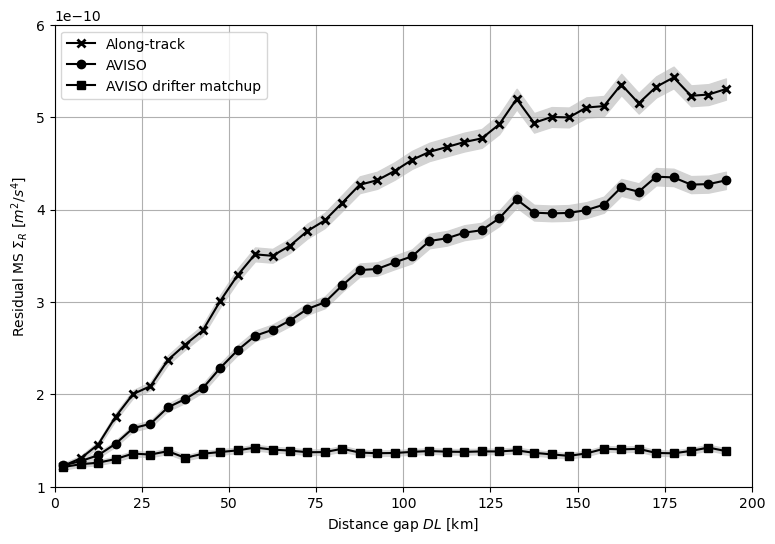

In [16]:
fig, ax = plt.subplots(1,1, figsize=(9,6))
dsd['sum_'+id_co].plot(label='Along-track', ax=ax, c='k', marker='x', markeredgewidth = 2,)
ax.fill_between(dsd.distbin, dsd['sum_'+id_co]-mserr['sum_'+id_co], dsd['sum_'+id_co]+mserr['sum_'+id_co], color='lightgrey')
dsd['sum_'+id_aviso].plot(label='AVISO', ax=ax, c='k', marker='o')
ax.fill_between(dsd.distbin, dsd['sum_'+id_aviso]-mserr['sum_'+id_aviso], dsd['sum_'+id_aviso]+mserr['sum_'+id_aviso], color='lightgrey')
dsd['sum_'+id_aviso_drifter].plot(label='AVISO drifter matchup', ax=ax, c='k', marker='s')
ax.fill_between(dsd.distbin, dsd['sum_'+id_aviso_drifter]-mserr['sum_'+id_aviso_drifter], dsd['sum_'+id_aviso_drifter]+mserr['sum_'+id_aviso_drifter], color='lightgrey')
ax.grid()
ax.legend()
ax.set_xlabel(r'Distance gap $DL$ [km]')
ax.set_ylabel(r'Residual MS $\Sigma_R$ $[m^2/s^4]$')
ax.set_xlim(0,200)
ax.set_ylim(1e-10,6e-10)

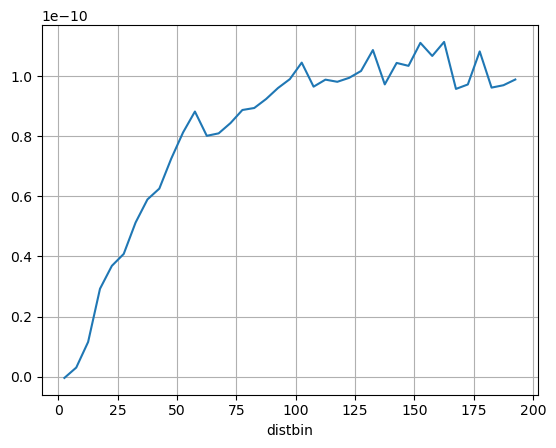

In [17]:
(dsd['sum_'+id_co]-dsd['sum_'+id_aviso]).plot()
plt.grid()

_______
# Captured vs errors parts

In [18]:
def true_err_x(ds_, id_, dic) :
    dso = xr.Dataset()
    dso['S'] = ds_['sum_'+id_]
    for x in ['acc', 'coriolis', 'ggrad', 'wind']:
        X =dic[x]
        dso[x] = ds_[X]
        dso['exc_'+x] = ds_['exc_' + x +'_'+ id_]
        dso['true_'+x] = (ds_[X] - ds_['sum_'+id_] + ds_['exc_' + x +'_'+ id_])/2
        dso['err_'+x] = (ds_[X] + ds_['sum_'+id_] - ds_['exc_' + x +'_'+ id_])/2
        
    dso['sum_x']=dso['acc']+dso['coriolis']+dso['ggrad']+dso['wind']
    dso['sum_truex']=dso['true_acc']+dso['true_coriolis']+dso['true_ggrad']+dso['true_wind']
    dso['sum_errx']=dso['err_acc']+dso['err_coriolis']+dso['err_ggrad']+dso['err_wind']
    return dso
    
dsdt = xr.concat([true_err_x(dsd, id_co, id_co_dic), true_err_x(dsd, id_aviso, id_aviso_dic)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))

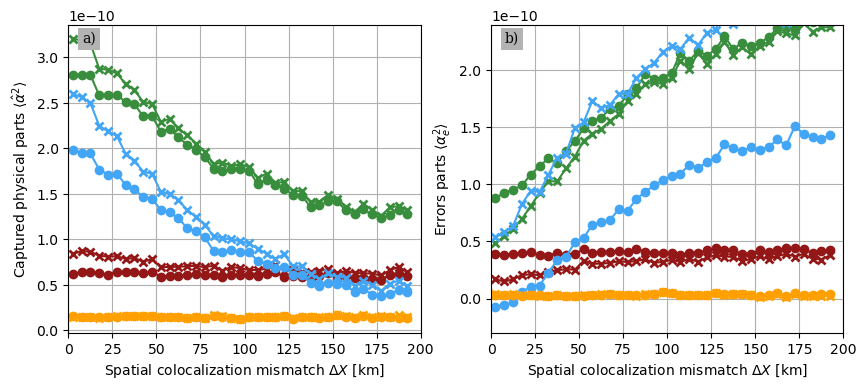

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
ax = axs[0]
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    dsdt.sel(id_comb=id_co)['true_'+v].plot(label='Along Track ' +v, color = c0[v], marker='x',markeredgewidth = 2, ax=ax)
    dsdt.sel(id_comb=id_aviso)['true_'+v].plot(label='AVISO ' +v, color = c0[v], marker='o', ax=ax)
#ax.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
ax.grid()
ax.set_xlim(0,200)
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r'Captured physical parts $\langle \hat{\alpha}^2 \rangle$')
ax.set_title('')
put_fig_letter(ax, 'a')

ax = axs[1]
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    dsdt.sel(id_comb=id_co)['err_'+v].plot(label='Along Track ' +v, color = c0[v], marker='x',markeredgewidth = 2, ax=ax)
    dsdt.sel(id_comb=id_aviso)['err_'+v].plot(label='AVISO ' +v, color = c0[v], marker='o', ax=ax)
#ax.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
ax.grid()
ax.set_xlim(0,200)
ax.set_ylim(-3e-11,2.4e-10)
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r'Errors parts $\langle \alpha_e^2 \rangle$')
ax.set_title('')
put_fig_letter(ax, 'b')

_____________
_____________
# Total figure

In [44]:
# get handles, labels for next figure
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(1,1))
l = {'acc':'Inertial acceleration', 'coriolis':'Coriolis acceleration', 'ggrad':'Pressure gradient term', 'wind': 'Wind term'}
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    dsdt.sel(id_comb=id_co)['err_'+v].plot(color = c0[v], ax=ax, label =l[v] )
plt.close(fig)
handles_, labels_ = ax.get_legend_handles_labels()


fig, ax = plt.subplots(1, 1, sharex=True, figsize=(1,1))
dsdt.sel(id_comb=id_co)['err_'+v].plot(ls='--', color = 'k', ax=ax, label ='AVISO max.' )
dsdt.sel(id_comb=id_co)['err_'+v].plot(ls=':', color = 'k', ax=ax, label ='Along-track max.' )
plt.close(fig)
handles__, labels__= ax.get_legend_handles_labels()


#dummy item
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(1,1))
dsdt.sel(id_comb=id_co)['err_'+v].plot(ls='', color = 'w', ax=ax, label ='  ' )
plt.close(fig)
handles_dummy, labels_dummy= ax.get_legend_handles_labels()


born_co = ((dsd['exc_ggrad_co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x'] + dsd['alti_ggx_adt_filtered_ocean_tide_internal_tide'])*dsd['nb_coloc']).sum()/(dsd['nb_coloc']).sum()
born_co = xr.full_like(dsd['sum_'+id_co], born_co)
born_aviso = ((dsd['exc_ggrad_aviso__25__adt__es_cstrio_z15__alti_x'] + dsd['aviso_alti_ggx_adt'])*dsd['nb_coloc']).sum()/(dsd['nb_coloc']).sum()
born_aviso = xr.full_like(dsd['sum_'+id_co], born_aviso)

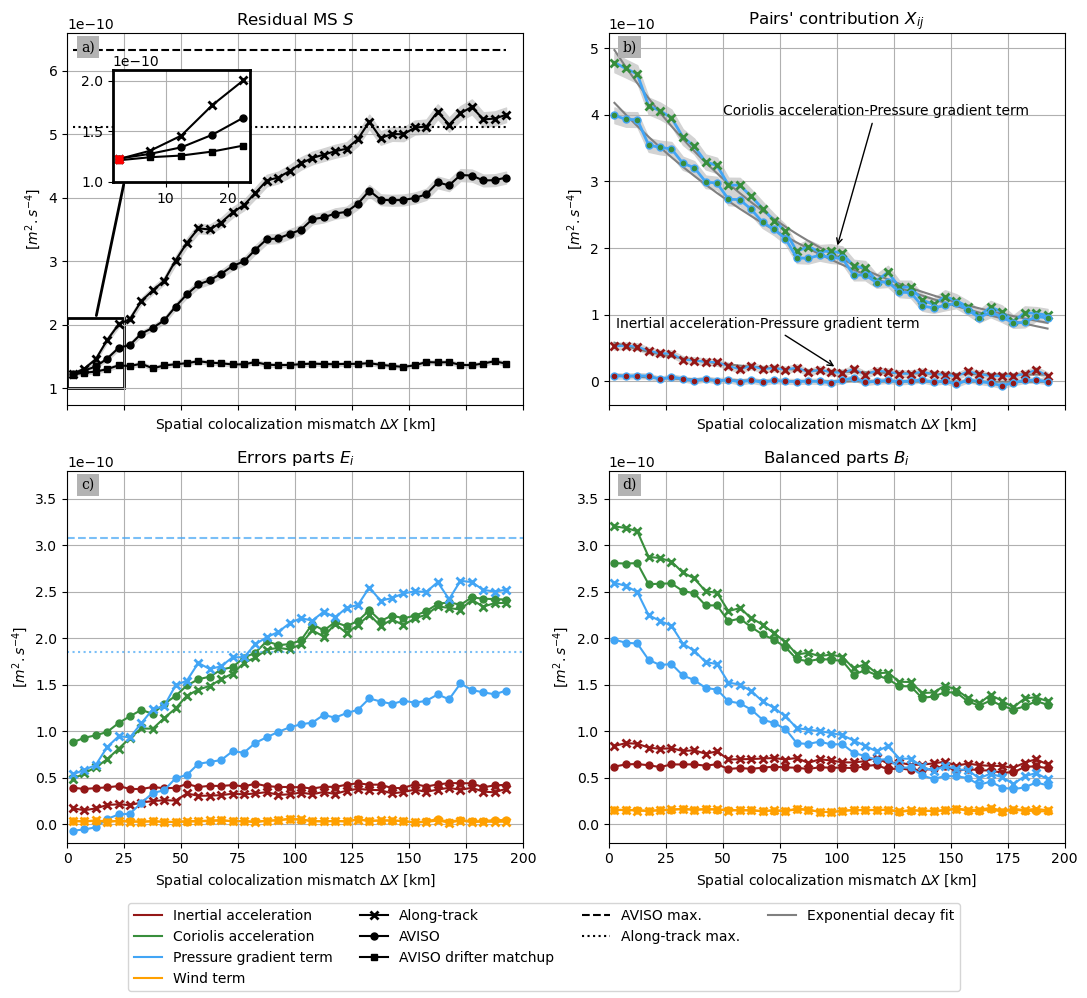

In [60]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(11,10), frameon=False)
axs =axs.flatten()

# plot param 
m =5 #markersize
a=0.7
ins_ax_box = [0.1,0.60,0.3,0.3]#[x0,y0,xlen, ylen]
import matplotlib.patches as patches

ax =axs[0]
dsd['sum_'+id_co].plot(label='Along-track', ax=ax, c='k', marker='x', markeredgewidth = 2,markersize=m+1)
dsd['sum_'+id_aviso].plot(label='AVISO', ax=ax, c='k', marker='o', markersize=m)
dsd['sum_'+id_aviso_drifter].plot(label='AVISO drifter matchup', ax=ax, c='k', marker='s', markersize=m,)
born_co.plot(ax=ax, color='k', ls = 'dashed')
born_aviso.plot(ax=ax,color='k', ls = ':')
ax.fill_between(dsd.distbin, dsd['sum_'+id_co]-mserr['sum_'+id_co], dsd['sum_'+id_co]+mserr['sum_'+id_co], color='lightgrey')
ax.fill_between(dsd.distbin, dsd['sum_'+id_aviso]-mserr['sum_'+id_aviso], dsd['sum_'+id_aviso]+mserr['sum_'+id_aviso], color='lightgrey')
ax.fill_between(dsd.distbin, dsd['sum_'+id_aviso_drifter]-mserr['sum_'+id_aviso_drifter], dsd['sum_'+id_aviso_drifter]+mserr['sum_'+id_aviso_drifter], color='lightgrey')

ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r"$[m^2.s^{-4}]$")
ax.set_title(r'Residual MS $S$')
put_fig_letter(ax, 'a')
handles0, labels0 = ax.get_legend_handles_labels()

#ZOOM
rect = patches.Rectangle((0, 1e-10), 25, 1.1e-10, linewidth=2, edgecolor='k', facecolor='none')
ax.add_patch(rect)
ins = ax.inset_axes(ins_ax_box)
dsd_ = dsd.sel(distbin=slice(0, 25))
dsd_['sum_'+id_co].plot(label='Along-track', ax=ins, c='k', marker='x', markeredgewidth = 2,markersize=m+1)
dsd_['sum_'+id_aviso].plot(label='AVISO', ax=ins, c='k', marker='o', markersize=m)
dsd_['sum_'+id_aviso_drifter].plot(label='AVISO drifter matchup', ax=ins, c='k', marker='s', markersize=m,)

ins.plot(dsd_['sum_'+id_co].isel(distbin=0).distbin, dsd_['sum_'+id_co].isel(distbin=0), color='r', marker='x', markeredgewidth = 2,markersize=m+1)
ins.plot(dsd_['sum_'+id_aviso].isel(distbin=0).distbin,dsd_['sum_'+id_aviso].isel(distbin=0), color='r', marker='o', markersize=m)
ins.plot(dsd_['sum_'+id_aviso_drifter].isel(distbin=0).distbin, dsd_['sum_'+id_aviso_drifter].isel(distbin=0), color='r', marker='s', markersize=m,)

ins.grid()
ins.spines['bottom'].set_color('k')
ins.spines['top'].set_color('k')
ins.spines['left'].set_color('k')
ins.spines['right'].set_color('k')
ins.spines['bottom'].set_linewidth(2)
ins.spines['top'].set_linewidth(2)
ins.spines['left'].set_linewidth(2)
ins.spines['right'].set_linewidth(2)
ins.set_xlabel('')
ins.set_ylabel('')
ins.set_ylim(1e-10, 2.1e-10)
ax.annotate('',xy=(12.5,2.1e-10),xytext=(25,4.25e-10),arrowprops={'arrowstyle':'-', 'color':'k', 'linewidth':2})


ax =axs[1]

exp_decay(cor_alg.distbin, *fit_cor_alg.curvefit_coefficients).plot(c='grey', label = 'Exponential decay fit', ax=ax)
exp_decay(acc_alg.distbin, *fit_acc_alg.curvefit_coefficients).plot(c='grey', ax=ax)
exp_decay(cor_av.distbin, *fit_cor_av.curvefit_coefficients).plot( c='grey', ax=ax)
exp_decay(acc_av.distbin, *fit_acc_av.curvefit_coefficients).plot( c='grey', ax=ax)
cor_alg.plot(c = c0['ggrad'], marker = 'x', markeredgewidth = 2, markeredgecolor=c0['coriolis'],markersize=m+1, lw=2, ax=ax)#,label= 'Coriolis acceleration - Pressure gradient estimated from along-track altimetry')
acc_alg.plot(c = c0['ggrad'], marker = 'x', markeredgewidth = 2, markeredgecolor=c0['acc'],markersize=m+1, ax=ax)#, label= 'Inertial acceleration - Pressure gradient estimated from along-track altimetry')
cor_av.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['coriolis'], markersize=m, lw=2, ax=ax)#, label= 'Coriolis acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')
acc_av.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['acc'], markersize=m, lw=2, ax=ax)#, label= 'Inertial acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')
ax.fill_between(e_cor_alg.distbin, cor_alg-e_cor_alg, cor_alg+e_cor_alg, color='lightgrey')
ax.fill_between(e_acc_alg.distbin, acc_alg-e_acc_alg, acc_alg+e_acc_alg, color='lightgrey')
ax.fill_between(e_cor_av.distbin, cor_av-e_cor_av, cor_av+e_cor_av, color='lightgrey')
ax.fill_between(e_cor_alg.distbin, acc_av-e_acc_av, acc_av+e_acc_av, color='lightgrey')

put_fig_letter(ax, 'b')
handles_exp, labels_exp = ax.get_legend_handles_labels()


ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r"$[m^2.s^{-4}]$")
ax.set_title(r"Pairs' contribution $X_{ij}$")
handles1, labels1 = ax.get_legend_handles_labels()

ax.annotate('Coriolis acceleration-Pressure gradient term', xy=(100, 2e-10), xytext=(50, 4e-10),
            arrowprops=dict(arrowstyle="->"))
ax.annotate('Inertial acceleration-Pressure gradient term', xy=(100, 0.2e-10), xytext=(3, 0.8e-10),
            arrowprops=dict(arrowstyle="->"))

ax = axs[2]

for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    dsdt.sel(id_comb=id_co)['err_'+v].plot(label='Along Track ' +v, color = c0[v], marker='x',markeredgewidth = 2,markersize=m+1, ax=ax)
    dsdt.sel(id_comb=id_aviso)['err_'+v].plot(label='AVISO ' +v, color = c0[v], marker='o',markersize=m, ax=ax)
    if v=='ggrad' : 
        ax.axhline(dsdt.sel(id_comb=id_co)[v].mean(), color = c0[v],  ls='--', alpha=a)
        ax.axhline(dsdt.sel(id_comb=id_aviso)[v].mean(), color = c0[v],  ls=':', alpha=a)
#ax.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
ax.set_xlim(0,200)
ax.set_ylim(-0.2e-10,3.8e-10)
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r"$[m^2.s^{-4}]$")
ax.set_title(r'Errors parts $E_i$')
put_fig_letter(ax, 'c')


ax=axs[3]

for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    dsdt.sel(id_comb=id_co)['true_'+v].plot(label='Along Track ' +v, color = c0[v], marker='x',markeredgewidth = 2,markersize=m+1, ax=ax)
    dsdt.sel(id_comb=id_aviso)['true_'+v].plot(label='AVISO ' +v, color = c0[v], marker='o',markersize=m, ax=ax)
    
#ax.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
ax.set_xlim(0,200)
ax.set_ylim(-0.2e-10,3.8e-10)
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r"$[m^2.s^{-4}]$")
ax.set_title(r'Balanced parts $B_i$')

put_fig_letter(ax, 'd')


for ax in axs :
    ax.grid()
handles, labels = handles_+handles0+handles_dummy+handles__+2*handles_dummy+handles_exp+3*handles_dummy, labels_+labels0+labels_dummy+labels__+2*labels_dummy+labels_exp+3*labels_dummy
fig.legend(handles, labels, ncols=4,loc='lower center')
fig.tight_layout(rect=[0,0.09,1,1])#left, bottom, right, top (default is 0,0,1,1)

fig.savefig('images/dist_total.png',bbox_inches='tight',   dpi=300)

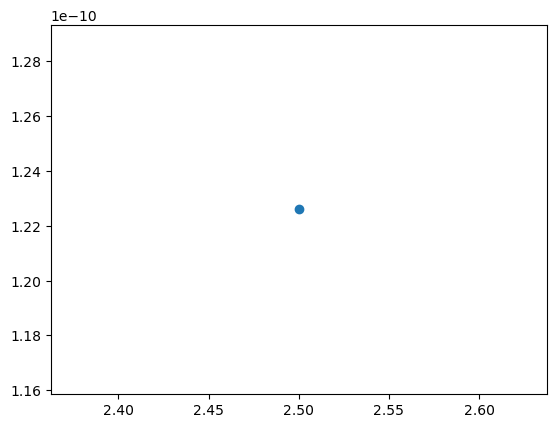

In [57]:
plt.plot(dsd_['sum_'+id_co].isel(distbin=0).distbin, dsd_['sum_'+id_co].isel(distbin=0), marker='o')

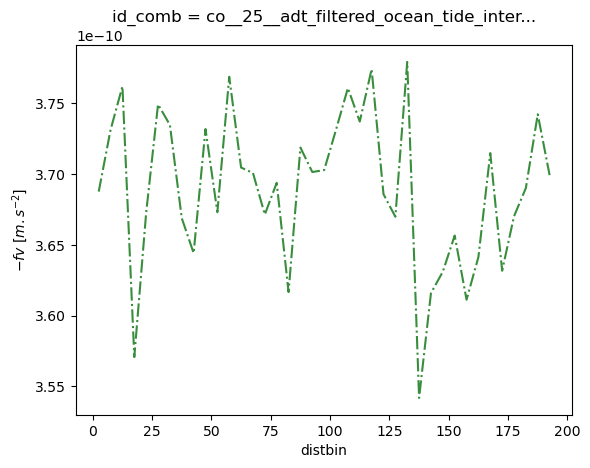

In [22]:
dsdt.sel(id_comb=id_co)['coriolis'].plot( color = c0['coriolis'],  ls='-.')

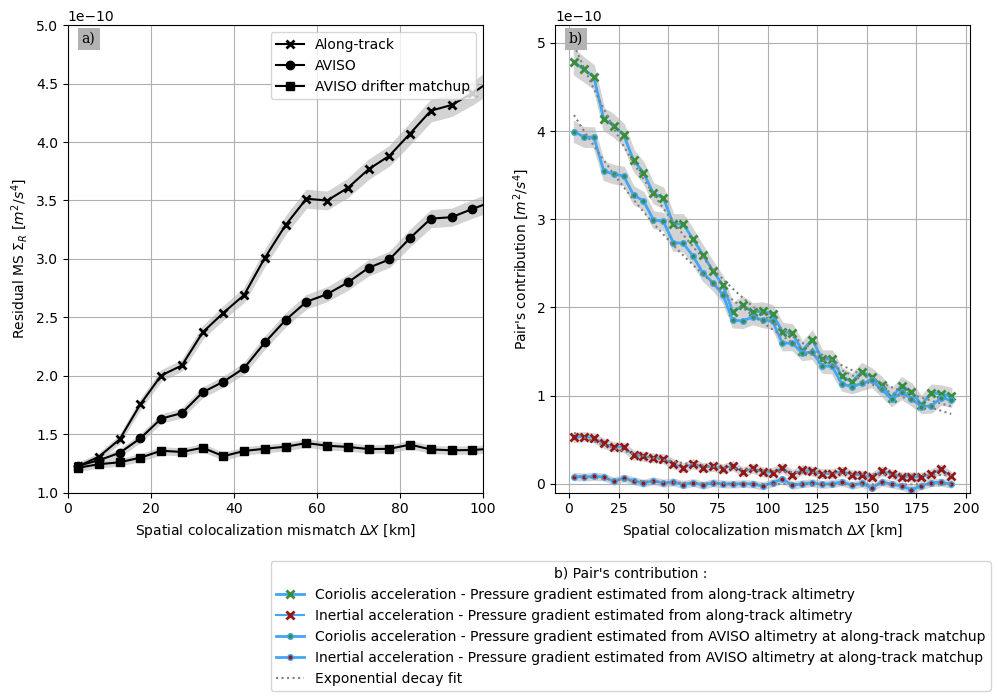

In [23]:
import matplotlib.transforms as mtransforms

fig, axs = plt.subplot_mosaic([['a)', 'b)']],layout='constrained', figsize=(10,7))

for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
    
ax =axs['a)']
dsd['sum_'+id_co].plot(label='Along-track', ax=ax, c='k', marker='x', markeredgewidth = 2,)
dsd['sum_'+id_aviso].plot(label='AVISO', ax=ax, c='k', marker='o')
dsd['sum_'+id_aviso_drifter].plot(label='AVISO drifter matchup', ax=ax, c='k', marker='s')
ax.fill_between(dsd.distbin, dsd['sum_'+id_co]-mserr['sum_'+id_co], dsd['sum_'+id_co]+mserr['sum_'+id_co], color='lightgrey')
ax.fill_between(dsd.distbin, dsd['sum_'+id_aviso]-mserr['sum_'+id_aviso], dsd['sum_'+id_aviso]+mserr['sum_'+id_aviso], color='lightgrey')
ax.fill_between(dsd.distbin, dsd['sum_'+id_aviso_drifter]-mserr['sum_'+id_aviso_drifter], dsd['sum_'+id_aviso_drifter]+mserr['sum_'+id_aviso_drifter], color='lightgrey')

ax.grid()
ax.legend()
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r'Residual MS $\Sigma_R$ $[m^2/s^4]$')
ax.set_xlim(0,100)
ax.set_ylim(1e-10,5e-10)
ax.legend(ncol=1, loc='upper right')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,

ax =axs['b)']
cor_alg.plot(c = c0['ggrad'], marker = 'x', markeredgewidth = 2, markeredgecolor=c0['coriolis'], lw=2, label= 'Coriolis acceleration - Pressure gradient estimated from along-track altimetry')
acc_alg.plot(c = c0['ggrad'], marker = 'x', markeredgewidth = 2, markeredgecolor=c0['acc'], label= 'Inertial acceleration - Pressure gradient estimated from along-track altimetry')
cor_av.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['coriolis'], markersize=4, lw=2, label= 'Coriolis acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')
acc_av.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['acc'], markersize=4, lw=2, label= 'Inertial acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')
ax.fill_between(e_cor_alg.distbin, cor_alg-e_cor_alg, cor_alg+e_cor_alg, color='lightgrey')
ax.fill_between(e_acc_alg.distbin, acc_alg-e_acc_alg, acc_alg+e_acc_alg, color='lightgrey')
ax.fill_between(e_cor_av.distbin, cor_av-e_cor_av, cor_av+e_cor_av, color='lightgrey')
ax.fill_between(e_cor_alg.distbin, acc_av-e_acc_av, acc_av+e_acc_av, color='lightgrey')


exp_decay(cor_alg.distbin, *fit_cor_alg.curvefit_coefficients).plot(ls=':', c='grey', label = 'Exponential decay fit')
exp_decay(acc_alg.distbin, *fit_acc_alg.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(cor_av.distbin, *fit_cor_av.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(acc_av.distbin, *fit_acc_av.curvefit_coefficients).plot(ls=':', c='grey')

ax.grid()
ax.set_title('')
ax.set_ylabel("Pair's contribution $[m^2/s^4]$")
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylim(-1e-11,5.2e-10)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=1,loc='lower right', title="b) Pair's contribution :")#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.savefig('images/dist_msre_cor.png',bbox_inches='tight',   dpi=300)

In [39]:
sco = compute_sum_ms(dsd, id_co, dic=id_co_dic)
sav = compute_sum_ms(dsd, id_aviso, dic=id_aviso_dic)
savd = compute_sum_ms(dsd, id_aviso_drifter, dic=id_aviso_drifter_dic)

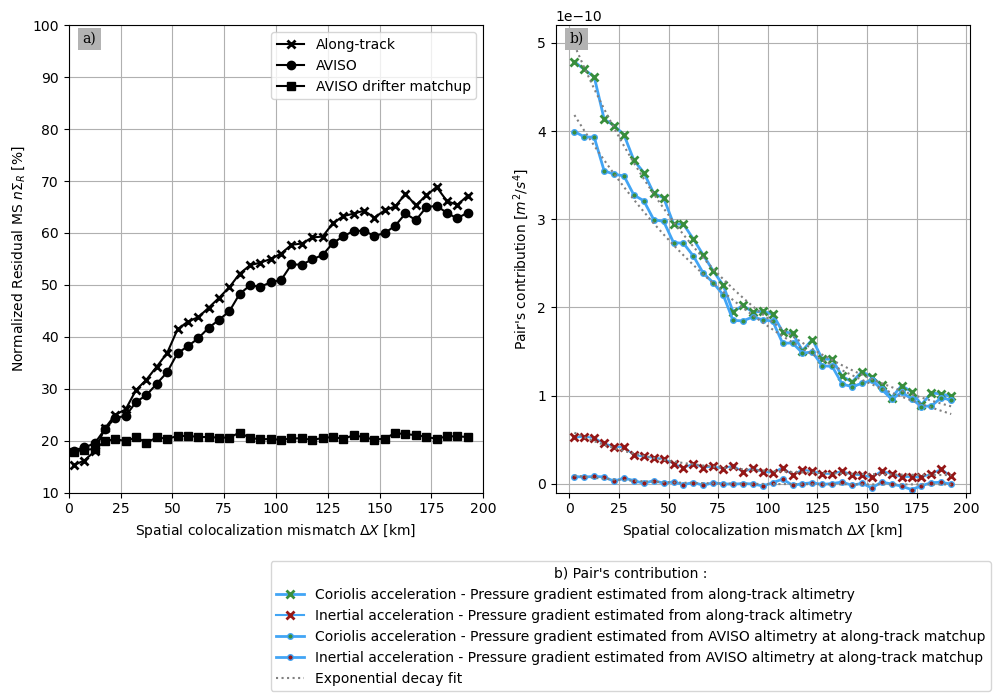

In [40]:
import matplotlib.transforms as mtransforms

fig, axs = plt.subplot_mosaic([['a)', 'b)']],layout='constrained', figsize=(10,7))

for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
    
ax =axs['a)']
(dsd['sum_'+id_co]/sco*100).plot(label='Along-track', ax=ax, c='k', marker='x', markeredgewidth = 2,)
(dsd['sum_'+id_aviso]/sav*100).plot(label='AVISO', ax=ax, c='k', marker='o')
(dsd['sum_'+id_aviso_drifter]/savd*100).plot(label='AVISO drifter matchup', ax=ax, c='k', marker='s')
#ax.fill_between(dsd.distbin, dsd['sum_'+id_co]-mserr['sum_'+id_co], dsd['sum_'+id_co]+mserr['sum_'+id_co], color='lightgrey')
#ax.fill_between(dsd.distbin, dsd['sum_'+id_aviso]-mserr['sum_'+id_aviso], dsd['sum_'+id_aviso]+mserr['sum_'+id_aviso], color='lightgrey')
#ax.fill_between(dsd.distbin, dsd['sum_'+id_aviso_drifter]-mserr['sum_'+id_aviso_drifter], dsd['sum_'+id_aviso_drifter]+mserr['sum_'+id_aviso_drifter], color='lightgrey')

ax.grid()
ax.legend()
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r'Normalized Residual MS $n\Sigma_R$ [%]')
ax.set_xlim(0,200)
ax.set_ylim(10,100)
ax.legend(ncol=1, loc='upper right')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,

ax =axs['b)']
cor_alg.plot(c = c0['ggrad'], marker = 'x', markeredgewidth = 2, markeredgecolor=c0['coriolis'], lw=2, label= 'Coriolis acceleration - Pressure gradient estimated from along-track altimetry')
acc_alg.plot(c = c0['ggrad'], marker = 'x', markeredgewidth = 2, markeredgecolor=c0['acc'], label= 'Inertial acceleration - Pressure gradient estimated from along-track altimetry')
cor_av.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['coriolis'], markersize=4, lw=2, label= 'Coriolis acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')
acc_av.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['acc'], markersize=4, lw=2, label= 'Inertial acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')


exp_decay(cor_alg.distbin, *fit_cor_alg.curvefit_coefficients).plot(ls=':', c='grey', label = 'Exponential decay fit')
exp_decay(acc_alg.distbin, *fit_acc_alg.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(cor_av.distbin, *fit_cor_av.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(acc_av.distbin, *fit_acc_av.curvefit_coefficients).plot(ls=':', c='grey')

ax.grid()
ax.set_title('')
ax.set_ylabel("Pair's contribution $[m^2/s^4]$")
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylim(-1e-11,5.2e-10)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=1,loc='lower right', title="b) Pair's contribution :")#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

______________
______________________
# Spatial Colocalization error estimation


In [41]:
## IMPORT GLOBAL MS ESTIMATION
DL =25*1e3 #meters
DT = 1800.0 #seconds
dsms = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'ms_{int(DL//1000)}_{DT}_drogued.zarr'))
gps = [l for l in dsms.drifter_sat_year.values if 'gps' in l]
dsmean = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'mean_{int(DL//1000)}_{DT}_drogued.zarr'))

ds, mslow, msup = global_ms_drifter_sat_year(dsmean.sel(drifter_sat_year=gps), dsms.sel(drifter_sat_year=gps), alpha=0.01)
mserr = (msup-mslow)/2

dste = true_err_x(ds, id_co, id_co_dic)

<xarray.DataArray 'nb_coloc' ()>
array(146030)


In [42]:
print('Along-track : msre25km-mindistmsre/msre25km = ',((ds['sum_'+id_co]-dsd['sum_'+id_co].isel(distbin=0))/ds['sum_'+id_co]*100).values)
print('AVISO : msre25km-mindistmsre/msre25km = ',((ds['sum_'+id_aviso]-dsd['sum_'+id_aviso].isel(distbin=0))/ds['sum_'+id_aviso]*100).values)

Along-track : msre25km-mindistmsre/msre25km =  21.08069509314467
AVISO : msre25km-mindistmsre/msre25km =  11.584476413387163


In [43]:
print('Along-track : msre25km-mindistmsre = ',(ds['sum_'+id_co]-dsd['sum_'+id_co].isel(distbin=0)).values)
print('AVISO : msre25km-mindistmsre = ',(ds['sum_'+id_aviso]-dsd['sum_'+id_aviso].isel(distbin=0)).values)

Along-track : msre25km-mindistmsre =  3.274766287782332e-11
AVISO : msre25km-mindistmsre =  1.6115257908045492e-11


In [44]:
dste[[v for v in dste if 'err_' in v]]

<xarray.Dataset>
Dimensions:       ()
Data variables:
    err_acc       float64 1.808e-11
    err_coriolis  float64 6.321e-11
    err_ggrad     float64 7.072e-11
    err_wind      float64 3.332e-12

In [45]:
dsdt.sel(id_comb=id_co).isel(distbin=slice(0,3))[[v for v in dste if 'err_' in v]]

<xarray.Dataset>
Dimensions:       (distbin: 3)
Coordinates:
  * distbin       (distbin) float64 2.5 7.5 12.5
    id_comb       <U71 'co__25__adt_filtered_ocean_tide_internal_tide__es_cst...
Data variables:
    err_acc       (distbin) float64 1.688e-11 1.491e-11 1.683e-11
    err_coriolis  (distbin) float64 4.851e-11 5.462e-11 6.118e-11
    err_ggrad     (distbin) float64 5.354e-11 5.831e-11 6.362e-11
    err_wind      (distbin) float64 3.663e-12 2.922e-12 4.019e-12

In [46]:
(dste-dsdt.sel(id_comb=id_co).isel(distbin=slice(0,1)).mean(dim='distbin'))[[v for v in dste if 'err_' in v]]

<xarray.Dataset>
Dimensions:       ()
Coordinates:
    id_comb       <U71 'co__25__adt_filtered_ocean_tide_internal_tide__es_cst...
Data variables:
    err_acc       float64 1.197e-12
    err_coriolis  float64 1.47e-11
    err_ggrad     float64 1.718e-11
    err_wind      float64 -3.319e-13

In [47]:
(dste-dsdt.sel(id_comb=id_co).isel(distbin=slice(0,1)).mean(dim='distbin'))/dste[[v for v in dste if 'err_' in v]]*100 #percentage of colocalization error

<xarray.Dataset>
Dimensions:       ()
Coordinates:
    id_comb       <U71 'co__25__adt_filtered_ocean_tide_internal_tide__es_cst...
Data variables:
    err_acc       float64 6.622
    err_coriolis  float64 23.26
    err_ggrad     float64 24.29
    err_wind      float64 -9.961

In [48]:
(dste-dsdt.sel(id_comb=id_co).isel(distbin=0))/dste[[v for v in dste if 'err_' in v]]*100

<xarray.Dataset>
Dimensions:       ()
Coordinates:
    distbin       float64 2.5
    id_comb       <U71 'co__25__adt_filtered_ocean_tide_internal_tide__es_cst...
Data variables:
    err_acc       float64 6.622
    err_coriolis  float64 23.26
    err_ggrad     float64 24.29
    err_wind      float64 -9.961

In [49]:
dste-dsdt.sel(id_comb=id_co).isel(distbin=0)

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    distbin        float64 2.5
    id_comb        <U71 'co__25__adt_filtered_ocean_tide_internal_tide__es_cs...
Data variables: (12/20)
    S              float64 3.275e-11
    acc            float64 1.359e-12
    exc_acc        float64 3.171e-11
    true_acc       float64 1.619e-13
    err_acc        float64 1.197e-12
    coriolis       float64 -1.81e-13
    ...             ...
    exc_wind       float64 3.289e-11
    true_wind      float64 -1.893e-13
    err_wind       float64 -3.319e-13
    sum_x          float64 -1.335e-13
    sum_truex      float64 -3.288e-11
    sum_errx       float64 3.275e-11

________________
_______________________
________
# Time


In [ ]:
dt=60

In [ ]:
files_ms = glob(os.path.join(zarr_dir+'_ok',f'mstime/mstime_{int(dt)}_drogued_*.zarr'))
files_ms = [f for f in files_ms if 'gps' in f]
files_mean = glob(os.path.join(zarr_dir+'_ok',f'meantime/meantime_{int(dt)}_drogued_*.zarr'))
files_mean = [f for f in files_mean if 'gps' in f]
files_corr = glob(os.path.join(zarr_dir+'_ok',f'corrtime/corrtime_{int(dt)}_drogued_*.zarr'))
files_corr = [f for f in files_corr if 'gps' in f]

In [ ]:
dsms = xr.open_mfdataset(files_ms)[var].rename({'nb_coloc_bin':'nb_coloc'}).compute()
dsmean = xr.open_mfdataset(files_mean)[var].rename({'nb_coloc_bin':'nb_coloc'}).compute()
dscorr = xr.open_mfdataset(files_corr).rename({'nb_coloc_bin':'nb_coloc'}).compute()

In [ ]:
gps = [l for l in dsms.drifter_sat_year.values if 'gps' in l]
dst, mslow, msup = global_ms_drifter_sat_year(dsmean.sel(drifter_sat_year=gps), dsms.sel(drifter_sat_year=gps), alpha=0.01)
mserrt = (msup-mslow)/2

dstc = -2* global_drifter_sat(dscorr)# balanced contribution
dstc['timebin']=dstc['timebin']/3600
dst['timebin']=dst['timebin']/3600
mserrt['timebin']=mserrt['timebin']/3600

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
dst['sum_'+id_co].plot(label='Along-track', ax=ax, c='k', marker='x', markeredgewidth=2)
ax.fill_between(dst.timebin, dst['sum_'+id_co]-mserrt['sum_'+id_co], dst['sum_'+id_co]+mserrt['sum_'+id_co], color='lightgrey')
dst['sum_'+id_aviso].plot(label='AVISO', ax=ax, c='k', marker='o')
ax.fill_between(dst.timebin, dst['sum_'+id_aviso]-mserrt['sum_'+id_aviso], dst['sum_'+id_aviso]+mserrt['sum_'+id_aviso], color='lightgrey')
dst['sum_'+id_aviso_drifter].plot(label='AVISO drifter matchup', ax=ax, c='k', marker='s')
ax.fill_between(dst.timebin, dst['sum_'+id_aviso_drifter]-mserrt['sum_'+id_aviso_drifter], dst['sum_'+id_aviso_drifter]+mserrt['sum_'+id_aviso_drifter], color='lightgrey')
ax.grid()
ax.legend()
ax.set_xlabel(r'Time colocalization mismatch $\Delta T$ [h]')
ax.set_ylabel(r'$\Sigma_R$ $[m^2/s^4]$')
ax.set_xlim(0,1)
ax.set_ylim(0,5e-10)
fig.savefig('images/time_msre.png',bbox_inches='tight',   dpi=300)

In [ ]:
dst.sel(timebin=slice(0, 0.5))

In [ ]:
dst_ =dst.sel(timebin=slice(0, 0.5))
mserrt_ =mserrt.sel(timebin=slice(0, 0.5))
fig, ax = plt.subplots(1,1, figsize=(10,4))
dst_['sum_'+id_co].sel(timebin=slice(0, 0.5)).plot(label='Along-track', ax=ax, c='k', marker='x', markeredgewidth=2)
ax.fill_between(dst_.timebin, dst_['sum_'+id_co]-mserrt_['sum_'+id_co], dst_['sum_'+id_co]+mserrt_['sum_'+id_co], color='lightgrey')
dst_['sum_'+id_aviso].plot(label='AVISO', ax=ax, c='k', marker='o')
ax.fill_between(dst_.timebin, dst_['sum_'+id_aviso]-mserrt_['sum_'+id_aviso], dst_['sum_'+id_aviso]+mserrt_['sum_'+id_aviso], color='lightgrey')
dst_['sum_'+id_aviso_drifter].plot(label='AVISO drifter matchup', ax=ax, c='k', marker='s')
ax.fill_between(dst_.timebin, dst_['sum_'+id_aviso_drifter]-mserrt_['sum_'+id_aviso_drifter], dst_['sum_'+id_aviso_drifter]+mserrt_['sum_'+id_aviso_drifter], color='lightgrey')
ax.grid()
ax.legend()
ax.set_xlabel(r'Time colocalization mismatch $\Delta T$ [h]')
ax.set_ylabel(r'Residual MS $S$ $[m^2/s^4]$')
ax.set_xlim(0,0.5)
ax.set_ylim(1e-10,2e-10)
fig.savefig('images/time_msre_zoom.png',bbox_inches='tight',   dpi=300)

______________________
# Count


In [ ]:
dsd.nb_coloc

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(9,6), sharex='col')
axs = axs.flatten()
ax = axs[0]
dsd.nb_coloc.plot(ax=ax, c='teal')
ax.legend()
ax.grid()
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel('Number of colocations per bin')
put_fig_letter(ax, 'a')

ax = axs[1]
dst.nb_coloc.plot(ax=ax, c='teal')
ax.legend()
ax.grid()
ax.set_xlabel(r'Time colocalization mismatch $\Delta T$ [h]')
ax.set_ylabel('Number of colocations per bin')
put_fig_letter(ax, 'b')

ax = axs[2]
dsd.nb_coloc.cumsum('distbin').plot(ax=ax, c='teal')
ax.legend()
ax.grid()
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel('Cumulative number of colocations')
put_fig_letter(ax, 'c', zorder=10)

ax = axs[3]
dst.nb_coloc.cumsum('timebin').plot(ax=ax, c='teal')
ax.legend()
ax.grid()
ax.set_xlabel(r'Time colocalization mismatch $\Delta T$ [h]')
ax.set_ylabel('Cumulative number of colocations')
put_fig_letter(ax, 'd', zorder=10)

fig.tight_layout()


______________________
# OLD
___________
___________

# $x$ contribution : $C_{x_i} =\langle S_{-x_i}^2\rangle-\langle S^2 \rangle$  and $Rcn_{x_i} = \frac{\langle S_{-x_i}^2\rangle-\langle S^2 \rangle}{\sum_i \langle x_i^2 \rangle}$
## Under H1 :
$Rc_{x_i} = \frac{\langle \hat{x}^2 \rangle - \langle {x_i^{e}}^2\rangle}{\sum_i \langle x_i^2 \rangle}$  

 - $RC_{x_i}<0 \Leftrightarrow \langle \hat{x}^2 \rangle < \langle {x_i^{e}}^2\rangle$ more error than signal is added
 - $RC_{x_i}>0 \Leftrightarrow \langle \hat{x}^2 \rangle > \langle {x_i^{e}}^2\rangle$ more signal than error is added
 - The bigger $Rc_x$ is, the better closure we have
Results :
 - $RC_x$<0 for inertial acceleration and wind

In [ ]:
def RC_x(ds, id_, dic=None):
    if isinstance(id_, str):
        lab = ['acc', 'coriolis', 'ggrad', 'wind']
        Rc_x = xr.Dataset()
        for l in lab :
            Rc_x[l] = (ds['exc_'+l+'_'+id_] - ds['sum_'+id_])
    return Rc_x
    
def RCn_x(ds, id_, dic=None):
    if isinstance(id_, str):
        lab = ['acc', 'coriolis', 'ggrad', 'wind']
        s = compute_sum_ms(ds, id_, dic)
        Rcn_x = xr.Dataset()
        for l in lab :
            Rcn_x[l] = (ds['exc_'+l+'_'+id_] - ds['sum_'+id_])/s
    return Rcn_x
    
RCXnd = xr.concat([RCn_x(dsd, id_co, dic = id_co_dic), RCn_x(dsd, id_aviso, dic = id_aviso_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb')) 
#RCXnt = xr.concat([RCn_x(dst, id_co, dic = id_co_dic), RCn_x(dst, id_aviso, dic = id_aviso_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb'))

RCXd = xr.concat([RC_x(dsd, id_co, dic = id_co_dic), RC_x(dsd, id_aviso, dic = id_aviso_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb')) 
#RCXt = xr.concat([RC_x(dst, id_co, dic = id_co_dic), RC_x(dst, id_aviso, dic = id_aviso_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb')) 

In [ ]:

plt.figure(figsize=(6,3))
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    RCXnd.sel(id_comb=id_co)[v].plot(label='Along Track ' +v, color = term_color[v])
    RCXnd.sel(id_comb=id_aviso)[v].plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
plt.grid()
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$RC_{x_i}$')
plt.title('')


In [ ]:

plt.figure(figsize=(6,3))
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    RCXd.sel(id_comb=id_co)[v].plot(label='Along Track ' +v, color = term_color[v])
    RCXd.sel(id_comb=id_aviso)[v].plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend(ncol = 2, bbox_to_anchor=(0, -0.65), loc='lower left')
plt.grid()
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$C_{x}$ $[m^2/s^4]$')
plt.title('')
